[#air-polution-sensor](https://github.com/Johansmm/air-polution-sensor)

 # Spatial and temporal analysis of signals to detect drift of air quality sensors
 
The network of sensors allows to follow a complex phenomenon by observing the temporal evolution of the values in several points, and by crossing the information from one sensor to another. This allows, for example, to carry out a meteorological or seismic monitoring, by detecting a cloud or a tremor. However, the sensors used are sometimes subject to drift, wear and tear or possible interference, which makes some of the observed values false. It is therefore important to be able to determine if a sensor starts to drift in order to allow a good analysis of the data. Therefore, the objective of this project is to detect a drifting sensor (when and where) in a real sensor's network. For this, we will explore the usefulness of a particular mathematical tool: the graph space-time spectrogram. Such a tool allows to decompose a space-time series into a sum of space-time frequencies, in a similar way to Fourier analysis, but for signals in graphs.

In [1]:
# Libraries
%load_ext autoreload
%autoreload 2

# Basis libraries 
import sys, getpass, os, copy
import numpy as np
import scipy.signal
from matplotlib import rc
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import scipy.signal

# Library for boxplots
# font = {'family':'sans-serif','sans-serif':['Helvetica'], 'size':18}
# rc('font', **font)
# rc('text', usetex=True)

np.random.seed(0)

In [2]:
# Colab access
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

# If you work-directory don't match, please add the new path to pwd_list
cwd_list = ["/content/gdrive/My Drive/S5 Project: Air polution/air-polution-sensor/",
            "/content/gdrive/My Drive/Colab Notebooks/ProyectS5/air-polution-sensor/",
            os.path.join(os.getcwd(),"air-polution-sensor")]

for cwd in cwd_list:
    if os.path.isdir(cwd):
        %cd "$cwd"
        break
if os.path.split(os.getcwd())[-1] != "air-polution-sensor":
    print("[WARNING]: Incorrect working directory. Please add the fix-directory to the pwd_list.")
else: 
    print("[INFO]: Work directory: " + os.getcwd())

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/ProyectS5/air-polution-sensor
[INFO]: Work directory: /content/gdrive/My Drive/Colab Notebooks/ProyectS5/air-polution-sensor


## **Download database**
Initially, the project [air-polution-sensor](https://github.com/Johansmm/air-polution-sensor.git) contains some default databases, which must be decompressed. Additionally, a larger database should be downloaded. This process is presented below.

Note: Make sure you are inside the repository folder [air-polution-sensor](https://github.com/Johansmm/air-polution-sensor.git).

In [3]:
if not os.path.isdir("./data/origin_data"):
    if not os.path.isdir("./data"): os.mkdir("./data")
    if not os.path.isdir("./data/origin_data"): os.mkdir("./data/origin_data")
    !wget --output-document="./data/data.zip" "https://www.dropbox.com/sh/w1704rg9fd9z4pq/AABG3YCUMHTwbFhf3pKgti-Qa/PuneData_UseThis/August2019?dl=0&subfolder_nav_tracking=1"
    !unzip "./data/data.zip" -d "./data/origin_data"

if not os.path.isfile("./data/super_df.csv"):
    !unrar x "./data/super_df.rar" "./data/"

clear_output(wait = True)
print("[INFO]: Data downloaded successfully!")

[INFO]: Data downloaded successfully!


In [4]:
# Specific libraries
!pip install -r requirements.txt
from libraries.global_functions import *
from libraries.animation_utils import *

clear_output(wait = True)
print("[INFO]: Successfully loaded libraries!")

[INFO]: Successfully loaded libraries!


In [ ]:
# !sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config

## **Example of introduction**

In order to explain some function's of `global_functions` and `animation_utils` library, and give a first context of the problem, let's start with a particulars example. 

We will define sinusoidal signals for all the nodes of the network to be analyzed, presenting in the vertex 0 a drift behavior from a certain instant of time. We will then analyze different characteristics of the network using the Graph Fourier Transform (GFT).

In [5]:
# Constants
SPACE_GRAPH_ORDER, SPACE_KERNEL_SCALE = 40, 3
TIME_GRAPH_ORDER, TIME_KERNEL_SCALE = 50, 15
dT = 10.0/TIME_GRAPH_ORDER # Time sample
LEVEL_NOISE, BREAK_TIME, STD = 0.2, 20, 0.3 # LN, brownian Motion (BM) start-point and SD in BM

### Network implementation

Let's create two graphs that will represent the spatial and temporal dimension, respectively. The spatial network will be represented by a stochastic network (`create_stochastic_graph`), while the temporal notion will be provided by a path network (`create_path_graph`).

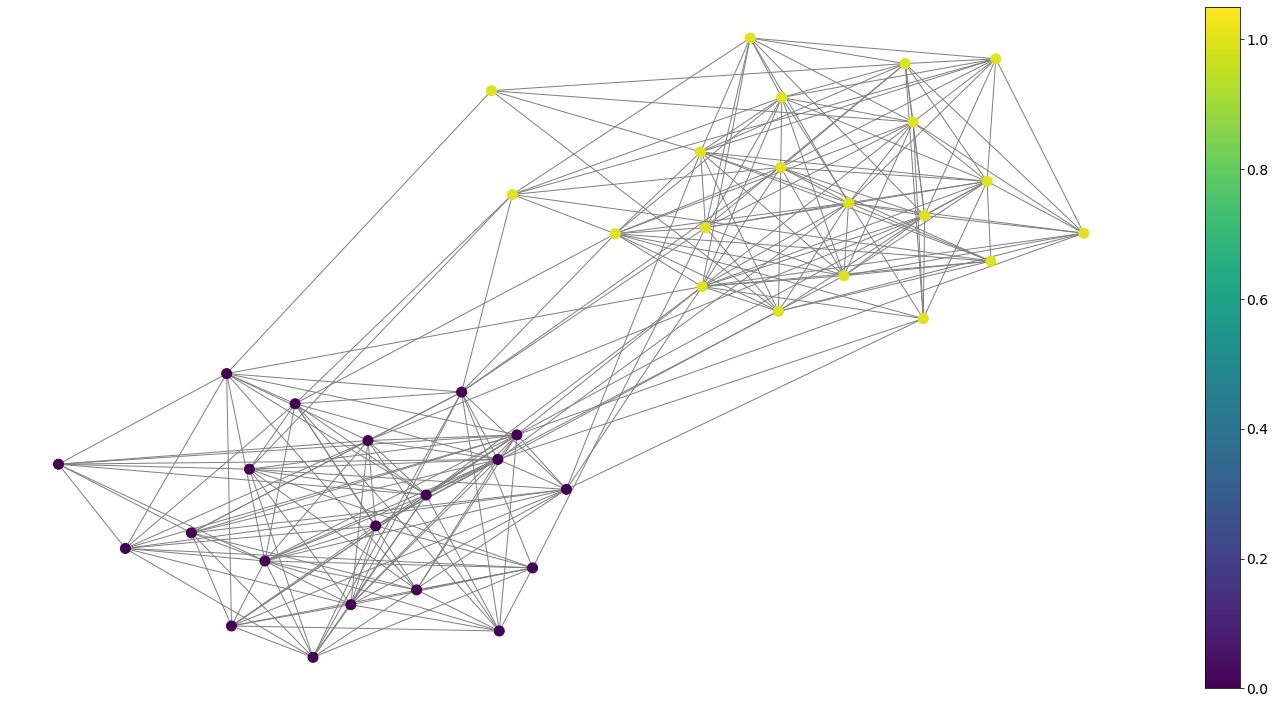

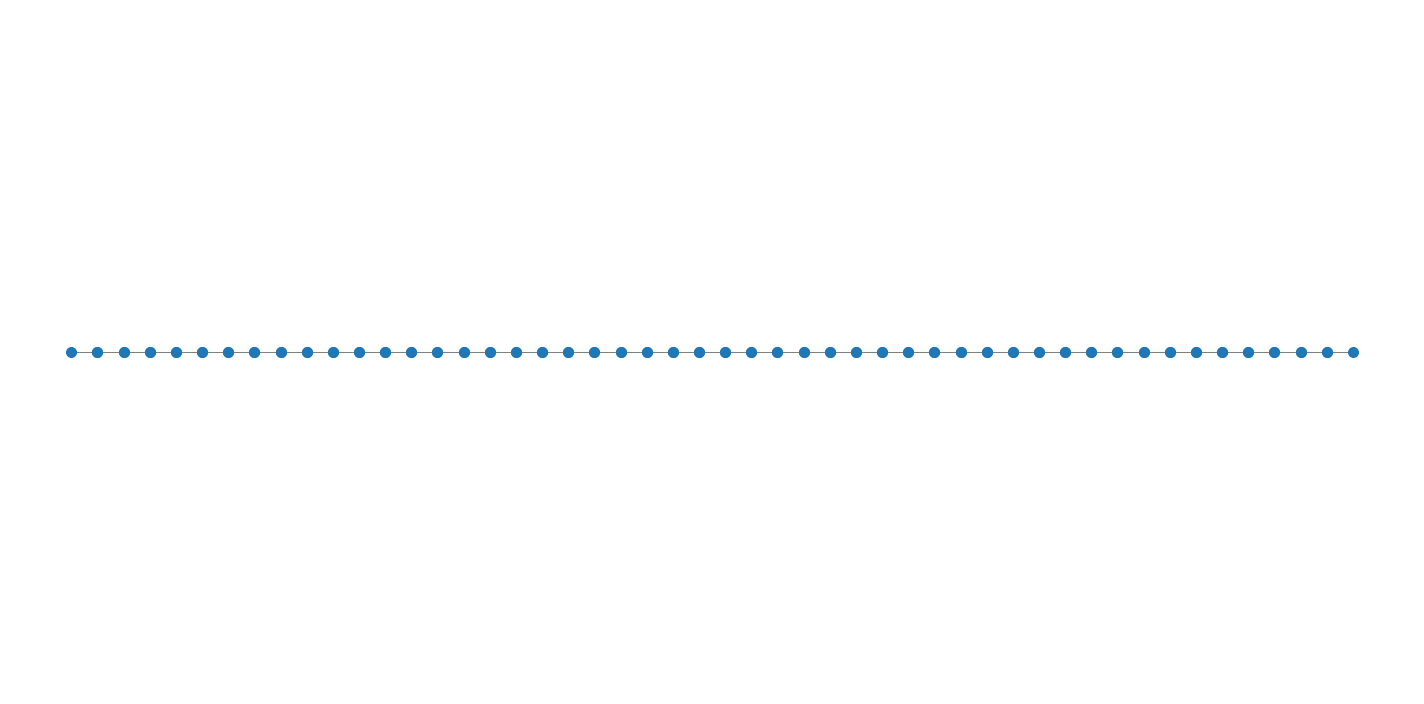

In [6]:
# Space-time graph definition
groups = np.array([0]*(SPACE_GRAPH_ORDER//2) + [1] * (SPACE_GRAPH_ORDER - SPACE_GRAPH_ORDER//2))
space_time_graph = [create_stochastic_graph(SPACE_GRAPH_ORDER, k = 2, z = groups, p=[0.6, 0.6], q = 0.05), 
         create_path_graph(TIME_GRAPH_ORDER)]

plot_graph(space_time_graph[0], groups)
plot_graph(space_time_graph[1])

### Signal definition
Now we create a function that defines the signal to be implemented on the space network. Let's see how each signal looks in all the vertex.

In [7]:
# Functions to signal definition
def brownian(x0, n, dt, delta, out = None):
    # https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html
    x0 = np.asarray(x0)
    
    # For each element of x0, generate a sample of n numbers from a normal distribution.
    r = np.random.normal(0.0, delta, x0.shape + (n,))*np.sqrt(dt)
    
    # If `out` was not given, create an output array.
    if out is None: out = np.empty(r.shape)
        
    # This computes the Brownian motion by forming the cumulative sum of the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)
    return out
    
def drift_signal(SGO = SPACE_GRAPH_ORDER, TGO = TIME_GRAPH_ORDER, BT = BREAK_TIME, 
                 dT = 1.0, nl = 0.01, delta = 2.0, groups = None, drift_vertex = 0):
    if groups is None:
        signal = np.sin(np.linspace(0, (TGO//BT)*4*np.pi, TGO)) # Signal base (until BREAK_TIME)
        time_series = np.ones((SGO,1))*signal[None] # Same signal for all nodes
    else:
        time_series = []
        for i in groups:
            t0 = 2*np.pi*i/len(np.unique(groups))
            time_series += [np.sin(np.linspace(0,(TGO//BT)*4*np.pi, TGO) + t0)]
        time_series = np.stack(time_series, axis = 0)
            
    time_series += nl * np.random.randn(*time_series.shape) # Add noise
    
    # Add Brownian Motion with t = BT start point
    brownian(time_series[drift_vertex,BT - 1], TGO - BT, dT, delta, out = time_series[drift_vertex,BT:])
    return time_series

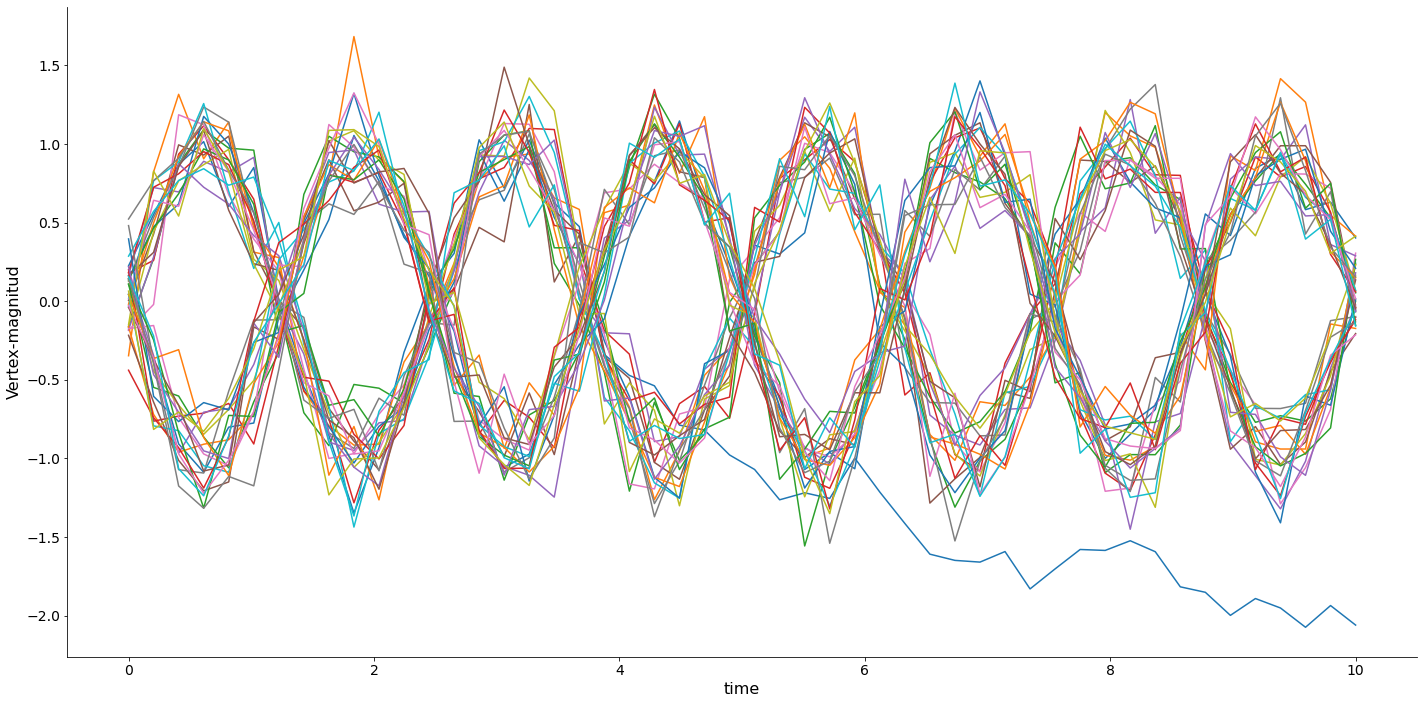

In [8]:
# Signal definition
time_series = drift_signal(dT = dT, nl = LEVEL_NOISE, BT = BREAK_TIME, delta = STD, groups = groups)

t = np.linspace(0, TIME_GRAPH_ORDER*dT, TIME_GRAPH_ORDER)
t = np.ones((SPACE_GRAPH_ORDER,1))*t[None]
plot_curves(t, time_series, xlabel = "time", ylabel = "Vertex-magnitud")

The signal inside the space-time graph would look like this.

In [9]:
signal_graph_anima(space_time_graph, time_series)

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function libraries.animation_utils.signal_graph_anima.<locals>.update>

### GFT in time and space

In this section we present functions to calculate the graph fourier transform in time and space

To check that the desired signal was processed correctly, the signal on a particular node and its Graph Fourier Transform (GFT) can be displayed with the following code section. Remember that the signal for the same group of nodes is the same. This can be seen again in the next cell, where the same procedure is presented for the temporary graph.

In [10]:
gft_signal_anima(space_time_graph[1], time_series, is_graph_space = True)

interactive(children=(Dropdown(description='Vertex', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

<function libraries.animation_utils.gft_signal_anima.<locals>.update>

In [11]:
gft_signal_anima(space_time_graph[0], time_series, is_graph_space = False)

interactive(children=(Dropdown(description='Instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function libraries.animation_utils.gft_signal_anima.<locals>.update>

Having correctly defined the signal to use, let's make a joint analysis of the space-time graph. 

### Spectrogram for disjoint GFT

To have a more detailed understanding, we will first analyze the graphs separately. The following function allows to display the spectrogram of each network by selecting a specific time (for the spatial graph) or a specific vertex (for the temporal graph), depending on the case.

In [12]:
spectogram_anima(space_time_graph[0], time_series, SKS = SPACE_KERNEL_SCALE, is_graph_space = True, limits = [0.0, 0.5])

interactive(children=(Dropdown(description='Instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function libraries.animation_utils.spectogram_anima.<locals>.update>

In [13]:
spectogram_anima(space_time_graph[1], time_series, SKS = TIME_KERNEL_SCALE, is_graph_space = False, limits = None)

interactive(children=(Dropdown(description='Vertex', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

<function libraries.animation_utils.spectogram_anima.<locals>.update>

* **Spatial-graph:** Let's remember that all the vertices in a group have the same signal, so, in a specific instant of time, the signal of each node is "constant". This is represented in the graphical-spatial spectrogram, where the only eigenvalues with considerable magnitudes are those of low order, which represent the low frequencies. As time passes, we see how the magnitudes of the nodes in group 0 begin to decrease, while those in group 1 begin to increase. However, this only happens at low frequencies.

* **Time-graph:** Focusing on the signal from only one particular node, we know that changes in sigmoidal and inverse sigmoidal signals are smooth, so your spectrogram will have non-null values in low order eigenvalues. Unlike the spatial spectogram, the presence of eigenvalues with magnitudes different from zero is evident, since the signal $s(v_i, t)$ for the vertex $v_i$ changes with time, unlike its counterpart, whose signal $s(v, t_j)$ is "constant" (without considering the introduced noise) at time $t_j$ for a group of vertices.  Finally, it is appreciated that, for the nodes of group0, the magnitudes of the spectogram increase through time, unlike the nodes of group0, whose behavior is inverse. 

### Spectrogram for joint GFT (JFT)
Now we will enter to observe the properties of the space-time joint spectrogram. This is possible thanks to the following function. Since the joint spectrogram is in principle a two-dimensional array for each possible combination in space and time, we have as a result an array in $\mathbb{R}^4$, being useful to indicate a specific vertex and instant, looking for interpretability.

In [14]:
kernels, joint_spectogram = JFT_anima(space_time_graph, time_series, [SPACE_KERNEL_SCALE, TIME_KERNEL_SCALE])

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

Taking into account that the joint spectrogram estimates different spectrograms, each of them centered on the combination ($v_i$, $t_j$), the analysis of the results should be done for each possible combination, arriving at the following statements:

1.  As explained above, the process occurs at "low frequencies" for any possible event, both in space and time, which directly affects the joint spectrogram, being only possible to see non-zero magnitudes in the upper left region (low orders of eigenvalues of space and time).
2.  The signal $s(v_i,t)$ has more frequency components compared to the signal $s(v,t_i)$, being possible to observe in the spectrogram for any combination. The reason is explained above.
3.  The magnitudes of the spectrogram for the combinations in the first instants of time and $v_i \in$ group0 or final instants of time and $v_i \in$ group1 are of low value in comparison to their counterpart, respectively. This is consistent with the shape of the signal at each vertex and for each instant of time.

## **Example with real sensor data**

In this section we will make an implementation with the real information about the location of the sensors to be treated in the project

### **Weight matrix**

In [ ]:
Theta, k = 4, 12   

First the adjacent matrix is imported then the thresholded Gaussian kernel weighting function is used to smooth the graph

In [ ]:
W = pd.read_csv('data/Pune_SensorLocationDistances.csv',header=0).set_index('0')
W.describe()

1          2          3          4          5          6  \
count  50.000000  50.000000  50.000000  50.000000  50.000000  50.000000   
mean    9.520506   5.964856   5.449465   6.467724   6.871216   7.123739   
std     4.025073   3.142605   3.300383   3.593118   3.411048   3.480089   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     7.368550   3.526350   3.523100   3.762225   4.506200   4.665425   
50%     9.038300   5.195400   5.203050   5.977850   6.607900   7.079300   
75%    11.178000   8.379425   6.377400   7.918525   9.005725   9.153775   
max    20.391000  13.028000  13.840000  15.925000  14.585000  15.210000   

               7          8          9         10  ...         42         43  \
count  50.000000  50.000000  50.000000  50.000000  ...  50.000000  50.000000   
mean    5.692812   4.711371   5.437952   5.422611  ...  10.503362   4.764719   
std     3.189542   2.938822   3.155138   3.282068  ...   3.820306   2.963033   
min     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
25%     3.134550   2.586850   3.180225   3.807925  ...   7.751250   2.545700   
50%     5.049650   3.837350   4.897350   5.090150  ...   9.910200   4.069400   
75%     7.735175   6.575750   7.493675   6.360950  ...  13.484750   6.913625   
max    13.047000  11.862000  11.424000  14.003000  ...  17.217000  12.679000   

              45         46         48         50         51         52  \
count  50.000000  50.000000  50.000000  50.000000  50.000000  50.000000   
mean    4.847406  12.201172   8.173570   5.250886   8.626384   7.637466   
std     2.969226   4.187344   3.689306   3.137798   4.019497   3.990063   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     2.521200   9.938025   6.096750   2.753825   6.017600   5.151775   
50%     4.240700  12.571500   7.711150   5.295250   8.716000   7.636500   
75%     7.027750  14.223500  10.211750   7.660025  10.757750   9.355275   
max    12.003000  22.261000  16.785000  12.086000  19.025000  16.632000   

              59         65  
count  50.000000  50.000000  
mean    4.977879   7.472454  
std     2.969335   3.093246  
min     0.000000   0.000000  
25%     2.914500   5.896375  
50%     4.461200   6.981400  
75%     6.960750   8.654825  
max    12.441000  15.538000  

[8 rows x 50 columns]

The histogram of the value of the distances is plotted,there are few connections with magnitudes greater than 15

In [ ]:
fig = go.Figure(data=[go.Histogram(x=W.to_numpy().flatten(),nbinsx=12,histnorm='probability density')])
fig.show()
fig = go.Figure(data=[go.Histogram(x=W.to_numpy().flatten(),nbinsx=12,histnorm='probability density',cumulative_enabled=True)])
fig.show()

Softening of the adjacent matrix is done. A histogram is performed to establish the k-threshold.

In [ ]:
W_normal2 = np.exp(-(W.copy()**2/(2*(Theta**2))))
#W_normal2 = W_normal2.replace([1],0)
#np.fill_diagonal(W_normal2.values, 0)
fig = go.Figure(data=[go.Histogram(x=W_normal2.to_numpy().flatten(),nbinsx=12)])
fig.show()

In [ ]:
Theta, k = 4, 5
W_normal = Norm_W(W.copy(),Theta,k) #Theta = 0.1 , k = 0.7
A=W_normal.values

In [ ]:
fig = go.Figure(data=[go.Histogram(x=W_normal.to_numpy().flatten(),nbinsx=12)])
fig.show()

The following graph shows the network with the original values of the adjacent matrix. 

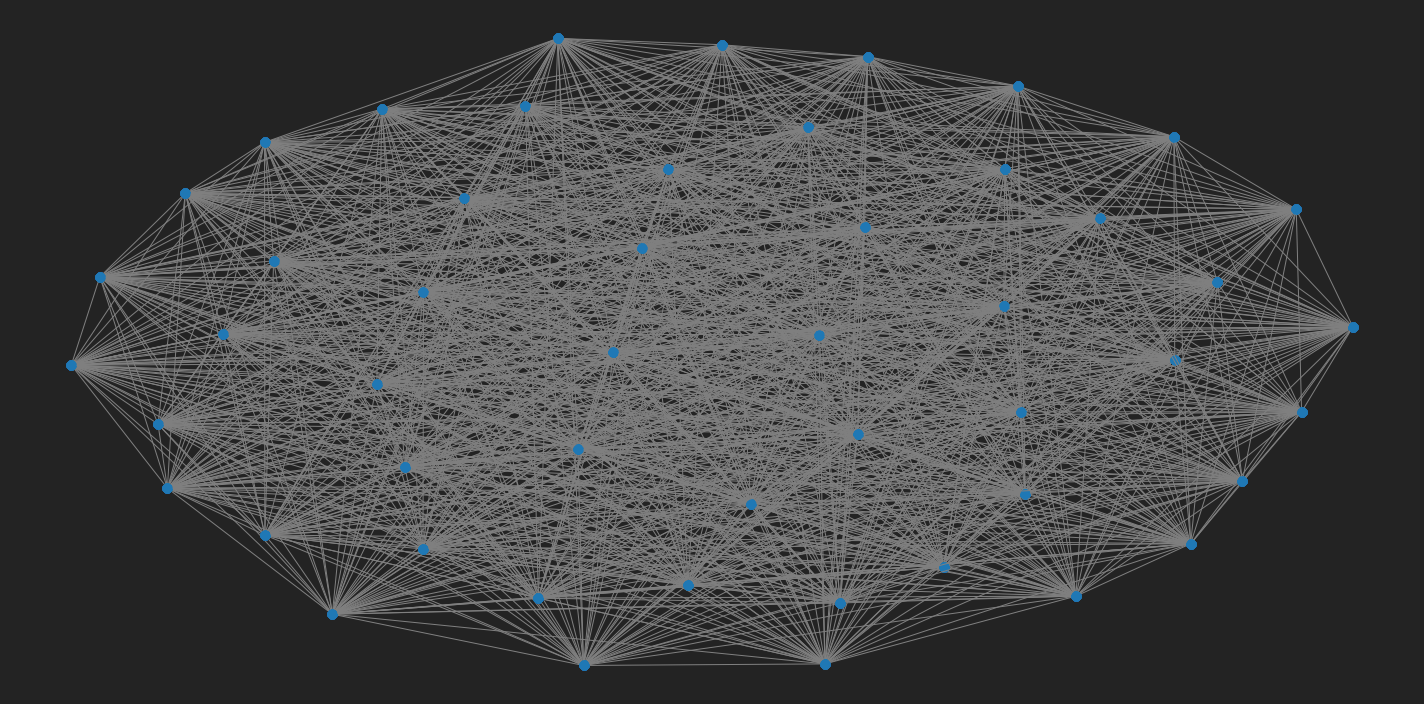

In [ ]:
G = create_graph(W)
plot_graph(G)

In [ ]:
W_aux=W.copy()
column=W_aux.columns.to_list()
W_aux[column] = W_aux[column].where(~(W_aux[column]>10),other=0)

The following chart shows the W chart limiting the network connections

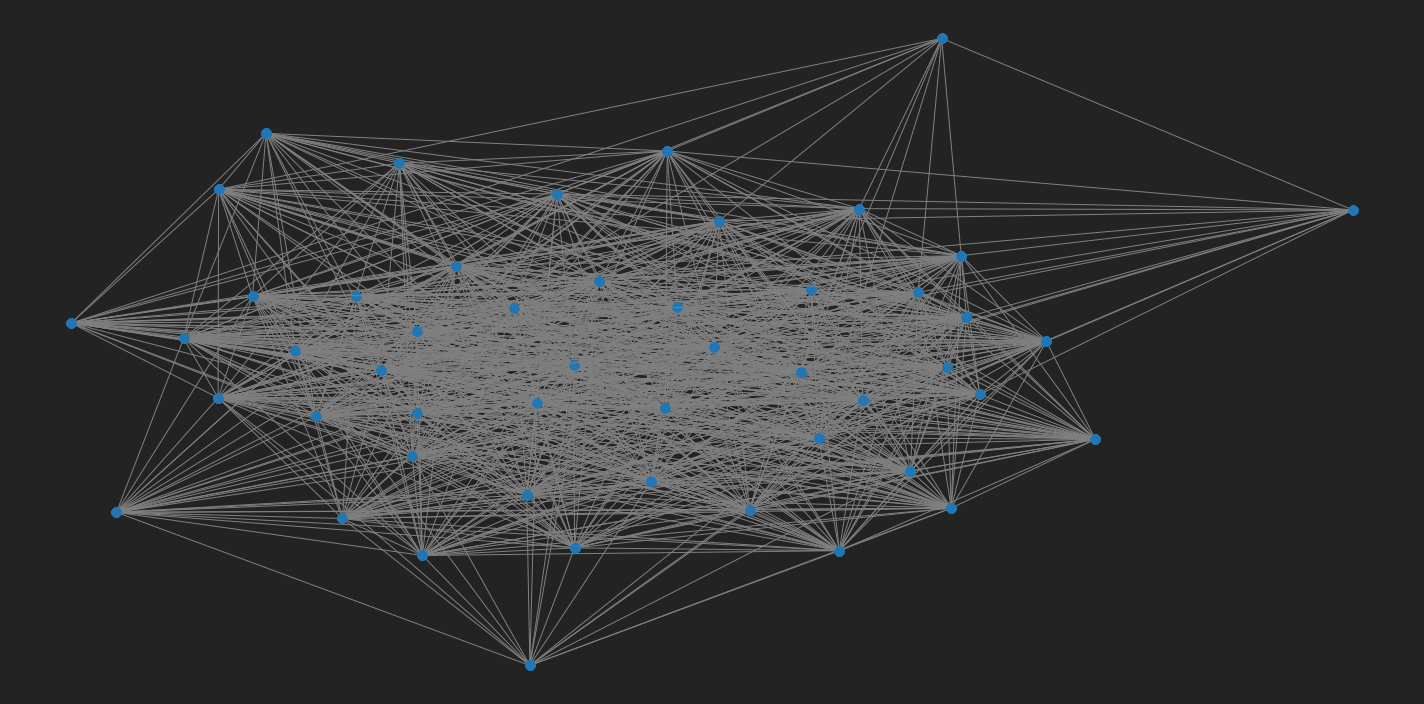

In [ ]:
G = create_graph(W_aux)
plot_graph(G)

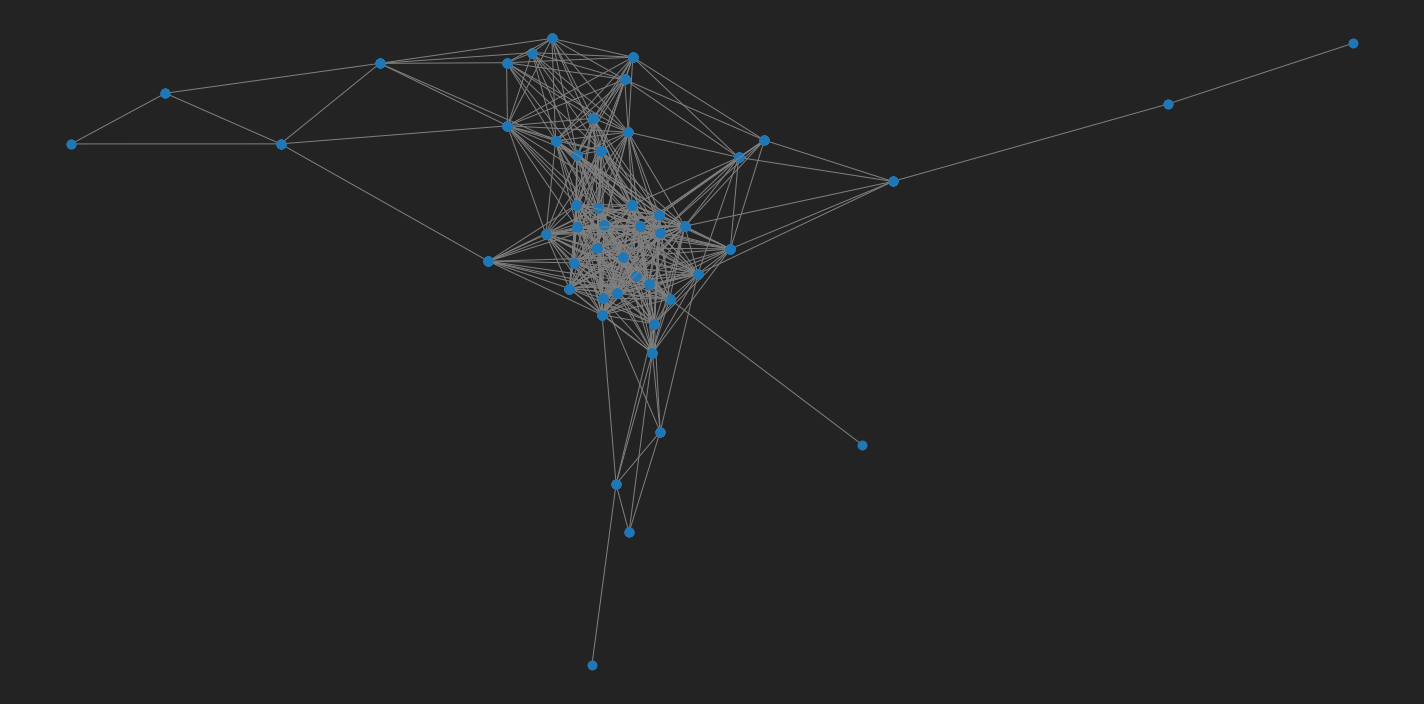

In [ ]:
G = create_graph(W_normal)
plot_graph(G)

In [ ]:
Theta, k = 4, 5
W_normal = Norm_W(W.copy(),Theta,k) #Theta = 0.1 , k = 0.7
A=W_normal.values

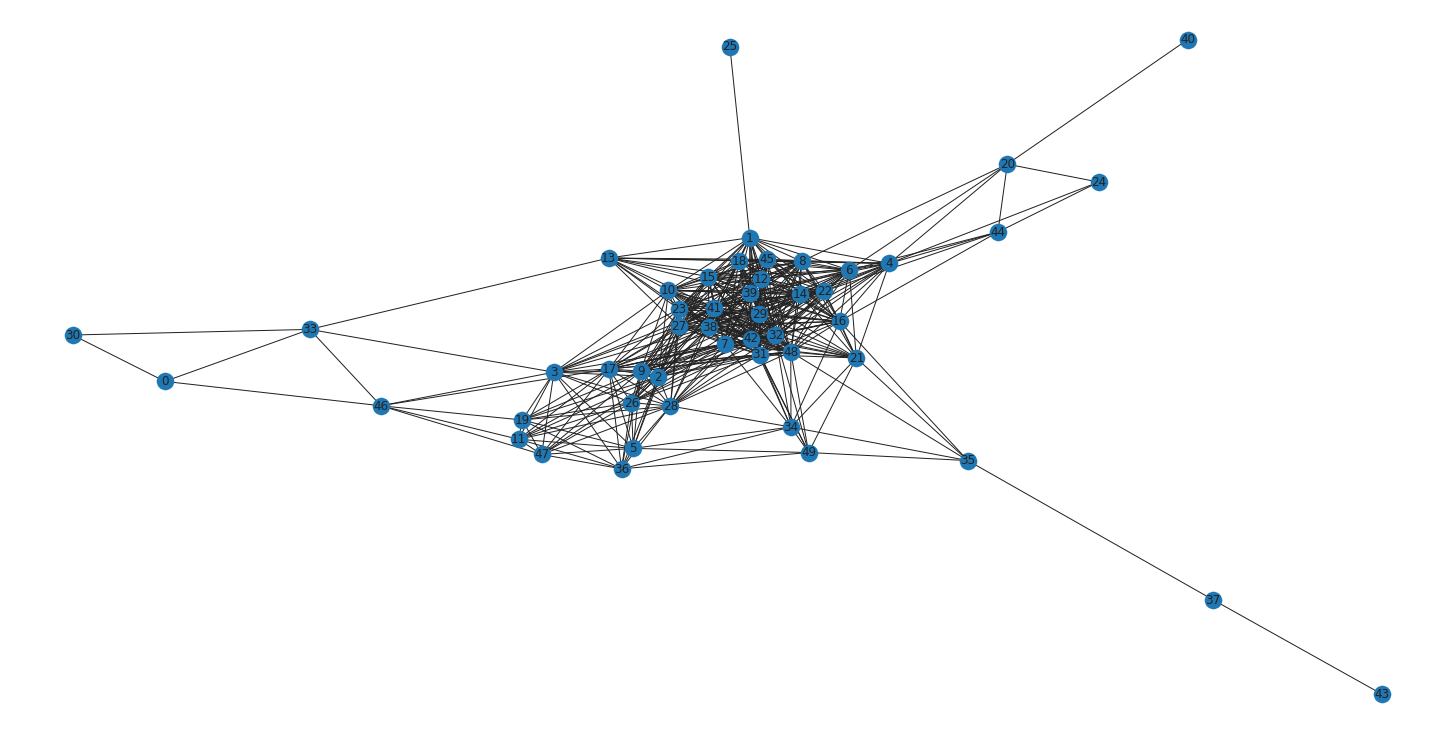

In [ ]:
import networkx as nx
dt = [('len', float)]
A = A.view(dt)

G = nx.from_numpy_matrix(A)
pos = nx.spring_layout(G, k=0.5*1/np.sqrt(len(G.nodes())), iterations=50)
figure = pyplot.figure(figsize=(20, 10))
nx.draw(G,pos=nx.spring_layout(G,pos=pos),with_labels = True)
xyz = np.array([pos[v] for v in sorted(G)])

#### Spectral clusterin 
[Source](https://towardsdatascience.com/unsupervised-machine-learning-spectral-clustering-algorithm-implemented-from-scratch-in-python-205c87271045)

In [ ]:
import matplotlib
from pygsp import graphs

A_s=W_normal.values
graph = graphs.Graph(A_s)
graph.set_coordinates(xyz)
graph.compute_fourier_basis()
# Plot

# graph.plotting['vertex_size'] = 150
# graph.plotting['indices']=True
# figure = pyplot.figure(figsize=(20, 10))
# graph.plot(ax=figure.gca(), )

In [ ]:
e = graph.e
v = graph.U

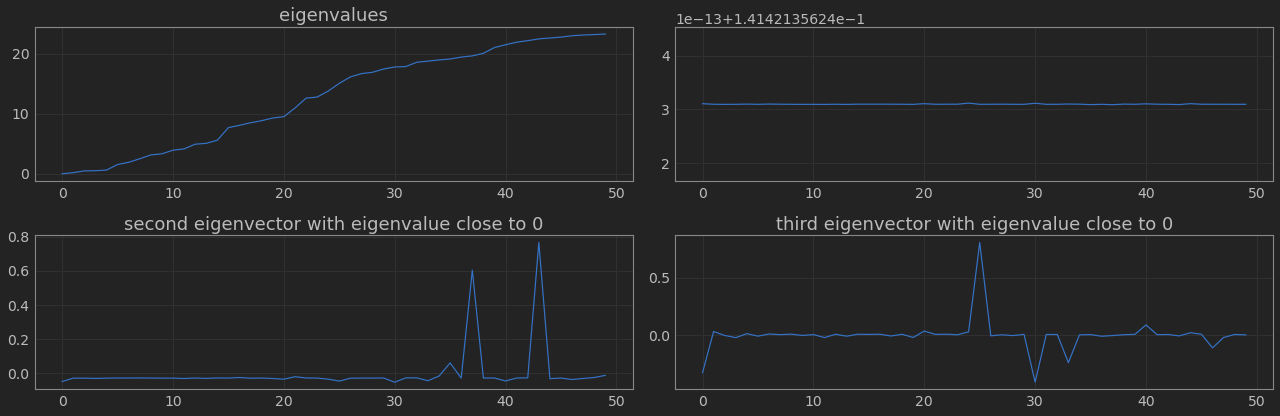

In [ ]:
fig = plt.figure(figsize=[18, 6])
ax1 = plt.subplot(221)
plt.plot(e)
ax1.title.set_text('eigenvalues')

i = np.where(e < 20)[0]
ax2 = plt.subplot(222)
plt.plot(v[:, i[0]])
#ax2.title.set_text('first eigenvector with eigenvalue')
ax3 = plt.subplot(223)
plt.plot(v[:, i[1]])
ax3.title.set_text('second eigenvector with eigenvalue close to 0')
ax4 = plt.subplot(224)
plt.plot(v[:, i[2]])
ax4.title.set_text('third eigenvector with eigenvalue close to 0')
fig.tight_layout()

In [ ]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first 
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

proj_df= project_and_transpose(e,v,10)

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

inertias = []

k_candidates = range(1, 20)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)

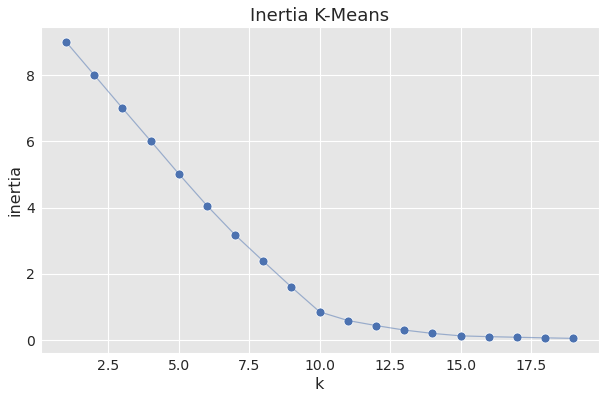

In [ ]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

In [ ]:
def run_k_means(df, n_clusters):
    """K-means clustering."""
    k_means = KMeans(random_state=25, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster

def spectral_clustering(eigenvals, eigenvcts, n_clusters):
    """Spectral Clustering Algorithm."""
    proj_df = project_and_transpose(eigenvals, eigenvcts, n_clusters)
    cluster = run_k_means(proj_df, proj_df.columns.size)
    return cluster

In [ ]:
Index_cluster= spectral_clustering(e,v,10)
index = np.argsort(Index_cluster)
print(np.sort(Index_cluster))
print(index)

[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 4 4 4
 4 4 4 4 4 4 4 5 6 7 8 8 9]
[ 0 33 21 22 45 48 27 29 31 32 34 38 39 41 42 44 20 18 23  8 16 15 14 13
 12  7  1  6  2 10  4  9 43 25  3  5 19 47 17 28 11 26 36 46 40 30 37 49
 35 24]


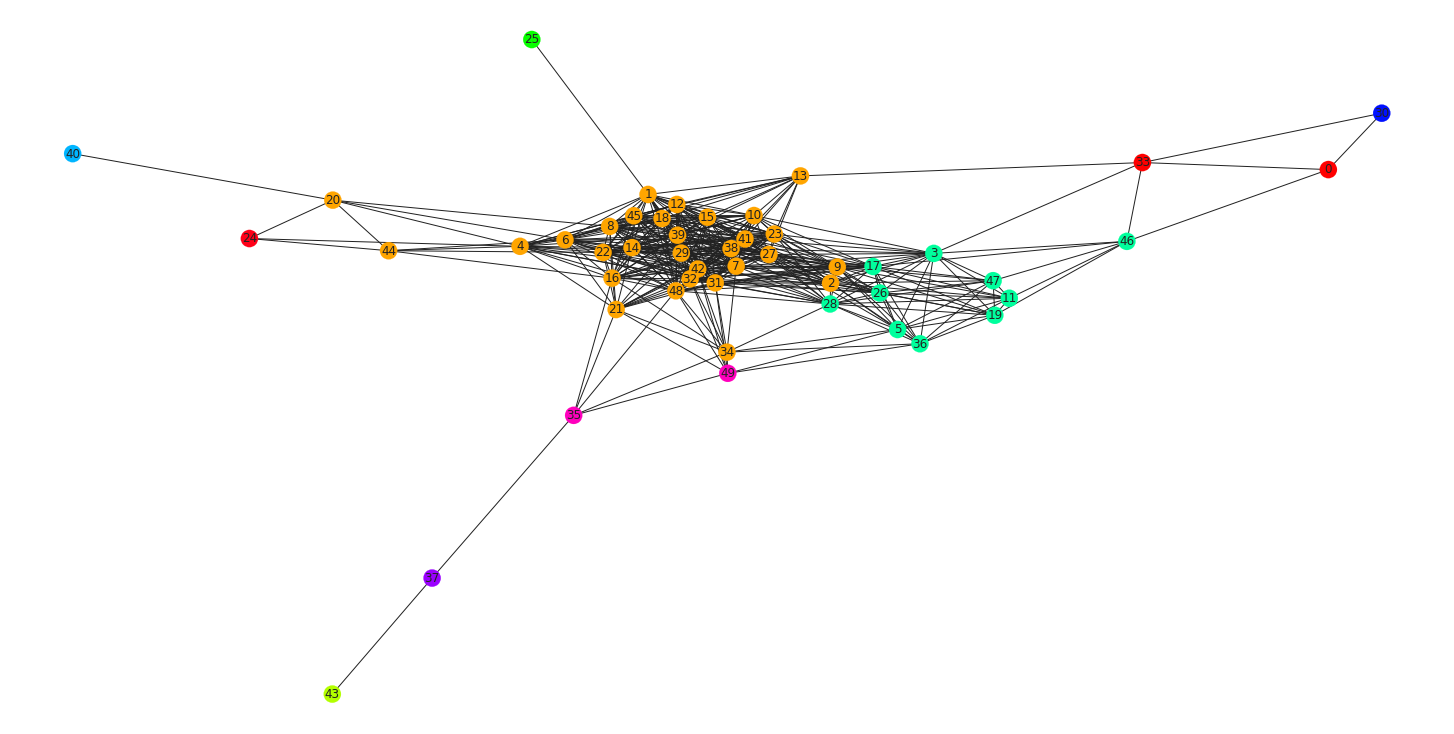

In [ ]:
dt = [('len', float)]
A_s = A_s.view(dt)
G = nx.from_numpy_matrix(A_s)
pos = nx.spring_layout(G, k=0.5*1/np.sqrt(len(G.nodes())), iterations=50)
figure = pyplot.figure(figsize=(20, 10))
nx.draw(G,pos=nx.spring_layout(G,pos=pos),with_labels = True,node_color = Index_cluster, cmap = 'hsv')

In [ ]:
SortW = W_normal.iloc[index,index]
A_s=SortW.values

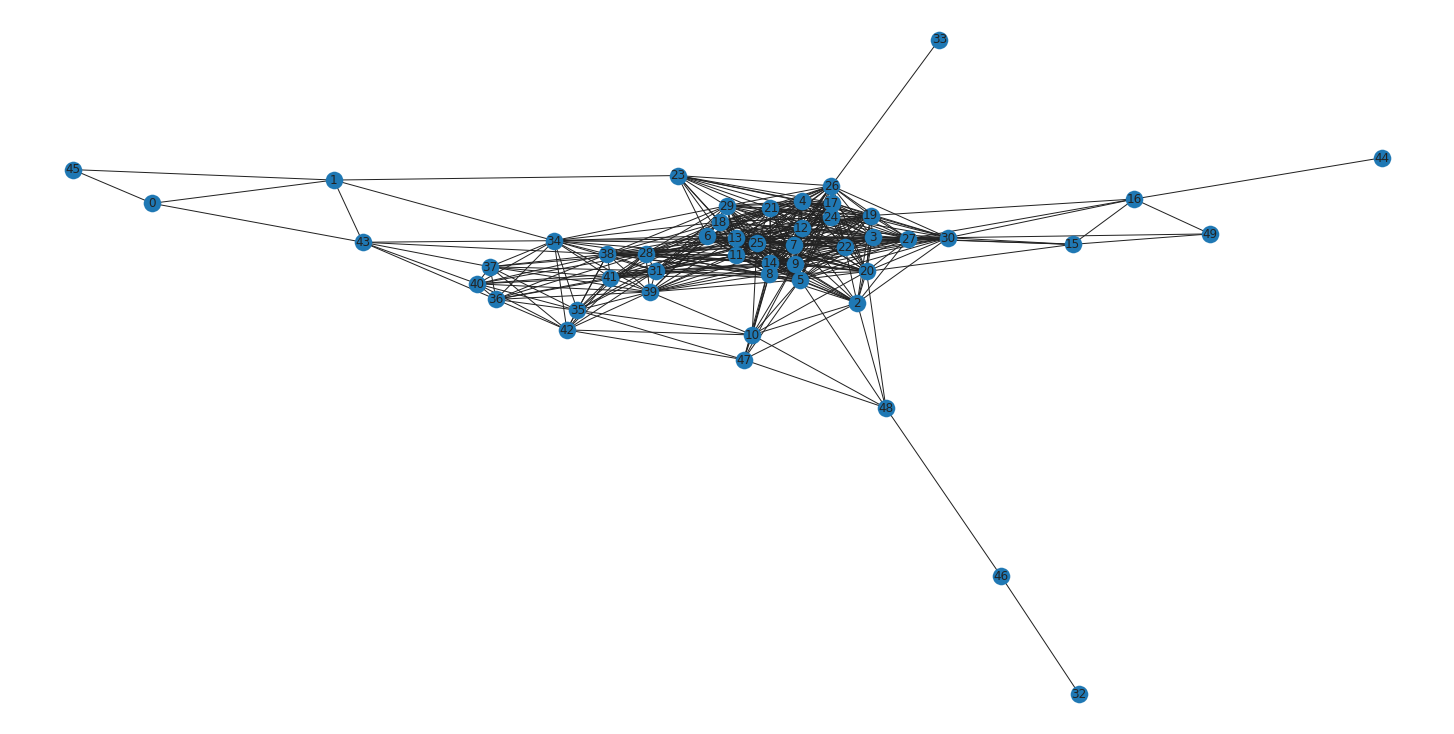

In [ ]:

dt = [('len', float)]
A_s = A_s.view(dt)

G = nx.from_numpy_matrix(A_s)
pos = nx.spring_layout(G, k=0.5*1/np.sqrt(len(G.nodes())), iterations=50)
figure = pyplot.figure(figsize=(20, 10))
nx.draw(G,pos=nx.spring_layout(G,pos=pos),with_labels = True)
xyz = np.array([pos[v] for v in sorted(G)])

In [ ]:
graph = graphs.Graph(A_s)
graph.set_coordinates(xyz)
graph.compute_fourier_basis()
plot_graph(graph)

TypeError: no supported conversion for types: (dtype([('len', '<f8')]),)

#### **Bandwidth Reduction** 

[source 1 ](https://https://algorist.com/problems/Bandwidth_Reduction.html)

[source 2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.reverse_cuthill_mckee.html)

In [ ]:
Theta, k = 4, 5
W_normal = Norm_W(W.copy(),Theta,k) #Theta = 0.1 , k = 0.7
A_b=W_normal.values

### **Signal generation**

To perform a test on how a signal would be observed in the network, a sinusoidal signal is generated with two different frequencies that vary in time t=30

In [ ]:
G=graph

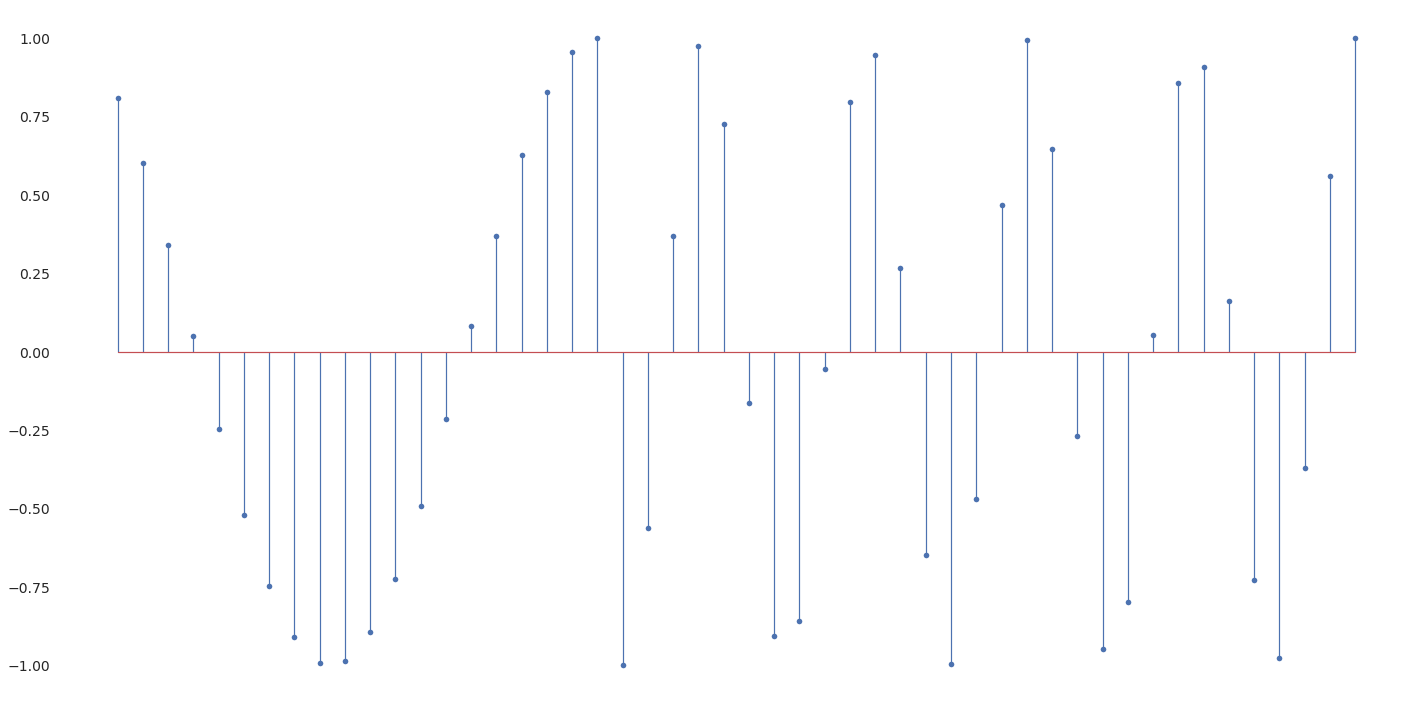

In [ ]:
df_signal=pd.DataFrame()

for i in range(31):
    N1=20+i
    N2=50-N1
    t1= np.linspace(0.1, N1, N1)
    t2= np.linspace(0.1, N2, N2)
    f1=1
    f2=5
    signal1=np.cos(2*np.pi*f1*t1)
    signal2=np.cos(2*np.pi*f2*t2)
    signal3=np.concatenate((signal1, signal2), axis=0)

    df_signal[i]=signal3


plot_stem(df_signal[0])

### **Space and time analysis**

In [ ]:
SPACE_GRAPH_ORDER_RS, SPACE_KERNEL_SCALE_RS = G.N, 10
TIME_GRAPH_ORDER_RS, TIME_KERNEL_SCALE_RS = 31, 10

AttributeError: 'Graph' object has no attribute 'N'

In [ ]:
signal = df_signal[30].values
space_time_graph2 = [G, create_path_graph(TIME_GRAPH_ORDER_RS)]

plot_graph(space_time_graph2[0],signal)
plot_graph(space_time_graph2[1])

NameError: name 'TIME_GRAPH_ORDER_RS' is not defined

In [ ]:
#time_series = signal_def(space_time_graph[0].N, space_time_graph[1].N, dT, nl = LEVEL_NOISE, plot_fun = False)
time_series2 = df_signal.to_numpy()
signal_graph_anima(space_time_graph2, time_series2)

NameError: name 'space_time_graph2' is not defined

#### **Vertex signal in time**
This section shows the evolution of the signal in time by vertex

In [ ]:
gft_signal_anima(space_time_graph2[1], time_series2, is_graph_space = True)

#### **Time evolution**

This section shows the evolution of the signal in time for all vertex

In [ ]:
gft_signal_anima(space_time_graph2[0], time_series2, is_graph_space = False)

#### **Joint Evolution**

The following graph shows the transformation of fourier in time in space. From the first graph it is possible to extract *the vertexes that have similar properties given an instant of time*, those that present similar variations in the signal. From the second it is possible to evaluate how the signal varies in time for a given vertex. *It is possible to determine at what moment the signal presents less variation (tendency to be constant)*.

In [ ]:
spectogram_anima(space_time_graph2[0], time_series2, SKS = SPACE_KERNEL_SCALE_RS, is_graph_space = True)#, limits = [0.0, 0.5])

In the following graph, it is possible to determine the behavior of the signal for a given vertex in an instant of time, in the same graph. How constant is the signal of a vertex in a given time lapse

In [ ]:
spectogram_anima(space_time_graph2[1], time_series2, SKS = TIME_KERNEL_SCALE_RS, is_graph_space = False)

## **Real signal analysis**

By observing a first view of the behavior of a signal that presents drift in one of its nodes, in order to understand its spectral representation, we can begin to analyze the signals captured by the sensor network. To do this, we must take a reading of the gas to be analyzed: PM, which is a measure of how polluted the air is at a location. We will then build a matrix containing the signal from each sensor per hour, from August 28 to October 28, 2019.

### Data read
Let's start with the reading of the signals, contained in the directory `air-polution-sensor/data/sensorv2/`.

In [ ]:
def readFileList(file_directory, ext = 'csv'): # Read a valid json-files inside folder / independenly file
    files_list = []
    if os.path.isdir(file_directory): # Return files with 'json' extension
        for root_path, _, files_name in os.walk(file_directory):
            files_list += [os.path.join(root_path, x) for x in files_name if x.split(".")[-1].lower() == ext.lower()]
    elif file_directory.split('.')[-1] == ext: files_list = [file_directory] # Return file inside of list
    return files_list

def sensor_read_signal(signal_name = "PM2_MOY"): # Read all signals and join in one matrix
    signals_list = readFileList("./data/sensorv2")
    signals = None
    for signal_file in signals_list:
        new_col_name = os.path.split(signal_file)[-1].replace("v2.csv","").replace("sensor","")
        new_col_name = int(new_col_name) # Only keep sensor id
        sig = pd.read_csv(signal_file).rename(columns = {signal_name: new_col_name}) # Read signal
        sig["Date"] = pd.to_datetime(sig["Date"] + " " + sig["Hour"].astype(str) + ":00:00")
        sig.set_index("Date", inplace = True)
        # Merge by date
        if signals is None: signals = sig[[new_col_name]].copy()
        else: signals = signals.merge(sig[[new_col_name]], copy = False, left_index = True, right_index = True)
    signals = signals.sort_index().T
    
    # Fill empty sensors with NaN values
    start, end = signals.index.min(), signals.index.max() # Find empty frames and fill in
    empty_sensors = sorted(set(range(start, end + 1)).difference(signals.index.values))
    if len(empty_sensors) > 0: 
        signals = signals.reindex(signals.index.to_list() + empty_sensors).fillna(0.0) # Comment fillna(0.0) to return NaN values
    return signals.sort_index().values # Comment .values to return dataframe

time_sensors_series = sensor_read_signal()
print(time_sensors_series.shape)
time_sensors_series#.head(30)

(59, 1488)


array([[400., 400., 400., ..., 400., 400., 400.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [400., 400., 400., ..., 400., 400., 400.]])

## ***Anexos: GitHub-Colab connection***
Here, some commands to upload/save the github respository

In [ ]:
''' Function definitions'''
# Git pull
def git_pull(repo_pwd, show_current_branch = False, make_commit = False): # Only for colab space work
    global user_git, email_git
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        # !git config --list
        if show_current_branch: 
            !git branch 
        if make_commit:
            if "user_git" not in globals(): user_git = input("User github?: ")
            if "email_git" not in globals(): email_git = input("Email github?: ") 
            !git config --global user.email $email_git
            !git config --global user.name $user_git
            !git commit -am "Updating in colab"
        !git pull
        !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

# Git push
def git_push(repo_pwd): # Only for colab space work
    global user_git, email_git
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        import getpass
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        if "user_git" not in globals(): user_git = input("User github?: ")
        if "email_git" not in globals(): email_git = input("Email github?: ")

        # Password login
        try: 
            pwd_git = getpass.getpass(prompt='{} github password: '.format(user_git)) 
        except Exception as error: 
            print('ERROR', error) 

        # Upload from every where
        origin_git = !git config --get remote.origin.url
        origin_git = origin_git[0].replace("https://","https://{}:{}@".format(user_git,pwd_git))

        !git config --global user.email "$email_git"
        !git config --global user.name "$user_git"
        !git status

        x = " "
        while x.lower() != "y" and x.lower() != "n": x = input("Continue?...[y/n]: ")

        if x.lower() == "y":
            com_message = input("Enter the commit message: ")
            !git add .
            !git commit -am "$com_message"
            !git push "$origin"
            !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

In order to execute the functions, please unlock the respective function

In [ ]:
# git_pull(repo_pwd, show_current_branch = False, make_commit = True)
# git_push(repo_pwd)